#Electricity prices forecasting-stage E quiz

In this quiz, we’ll explore and build time series forecasting models for measurements of electricity prices  of a District given the total amount of Electricity consumed in that District from 2010 to 2021.

Data Set Information:

The archive contains 92,016 measurements of electricity data gathered between September 2010 and February 2021.

Notes:

1. The dataset is sampled on an hourly basis. It has the following features:

Attribute Information:

FullDate: Date in format yyyy-mm-dd  <br> hh:mm:ss <br>
ElecPrice: Prices of electricity charged in Kw per hour<br>
Gas Price: power generated was done via a gas power plant, gas price is the price of gas at time-T <br>
SysLoad: Total Load on system or Power consumed at time-T <br>
Tmax: maximum temperature at time-T<br>

In [1]:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings('ignore')

import statsmodels

#Importing the ADF library
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from prophet import Prophet


In [2]:
#Load dataset from link
df = pd.read_csv('https://github.com/HamoyeHQ/HDSC-Time-series-analysis-and-forecast/files/7768846/Time_series_analysis_and_forecast_DATASET.csv')
df.head()


,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [3]:
df.tail()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
92011,2021-02-28 19:00:00,24.3,449.63625,5.4848,117.925
92012,2021-02-28 20:00:00,24.3,815.59975,5.4848,87.880
92013,2021-02-28 21:00:00,24.3,745.12325,5.4848,62.060
92014,2021-02-28 22:00:00,24.3,694.95150,5.4848,62.000
92015,2021-02-28 23:00:00,24.3,714.69630,5.4848,62.955


In [4]:
df.shape

(92016, 5)

In [5]:
df.dtypes

FullDate      object
Tmax         float64
SysLoad      float64
GasPrice     float64
ElecPrice    float64
dtype: object

In [6]:
#check for missing values
df.isnull().values.any(), df.isnull().sum()

(False,
 FullDate     0
 Tmax         0
 SysLoad      0
 GasPrice     0
 ElecPrice    0
 dtype: int64)

In [7]:
df.describe()

,Tmax,SysLoad,GasPrice,ElecPrice
count,92016.000000,92016.000000,92016.000000,92016.000000
mean,231.696688,797.623357,6.016163,65.798356
std,4562.128748,613.520156,2.608116,213.144084
min,9.900000,-1596.810100,0.000000,-924.820000
25%,17.300000,417.119800,3.936900,31.543750
50%,21.900000,856.467925,5.165600,48.715000
75%,27.600000,1221.293675,8.023300,76.495000
max,99999.900000,3264.166300,29.990000,14700.000000


Convert to a time series object - 'FullDate' to 'DateTime' 

In [8]:
df['FullDate'] = pd.to_datetime(df.FullDate)

# Rename the Columns FullDate And ElecPrice
df = df.rename(columns = {'FullDate': 'ds','ElecPrice': 'y'})
#set datetime as the index
df.set_index('ds',inplace = True)

df.head()

,Tmax,SysLoad,GasPrice,y
ds,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


Resampling the readings from Hourly to Daily data points

In [9]:
df_daily = df.resample('D').sum()
df_daily.head()

,Tmax,SysLoad,GasPrice,y
ds,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275
2010-09-05,357.6,35611.410,106.80,500.555


In [10]:
df_daily.tail()

,Tmax,SysLoad,GasPrice,y
ds,,,,
2021-02-24,537.6,-1525.49745,134.4000,634.770
2021-02-25,518.4,4539.07855,130.5048,577.515
2021-02-26,547.2,9517.02430,130.1808,1445.495
2021-02-27,564.0,4932.88015,130.0800,488.980
2021-02-28,583.2,6675.05485,131.6352,-98.985


In [11]:
df_daily.corr()

,Tmax,SysLoad,GasPrice,y
Tmax,1.000000,-0.012249,0.030173,0.004748
SysLoad,-0.012249,1.000000,-0.268321,0.170524
GasPrice,0.030173,-0.268321,1.000000,0.352420
y,0.004748,0.170524,0.352420,1.000000


In [12]:
df_daily.shape

(3834, 4)

 Viaualize the Daily ElecPrice over time

[]

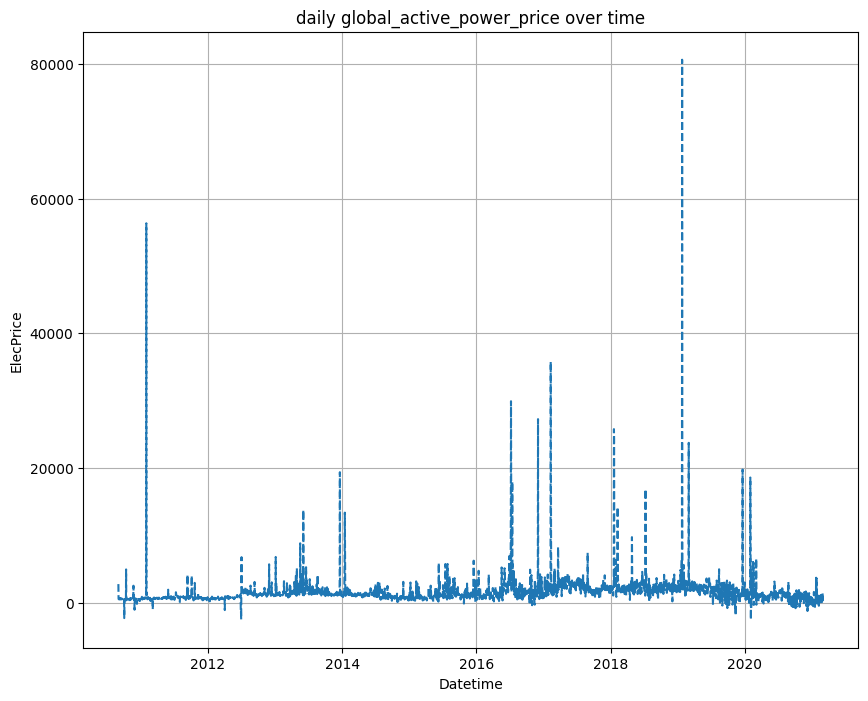

In [13]:
#plot of the daily global_active_power over time
plt.figure(figsize=(10,8))
plt.plot(df_daily.index, df_daily.y, '--')
plt.grid()
plt.xlabel('Datetime')
plt.ylabel('ElecPrice')
plt.title ('daily global_active_power_price over time')
plt.plot()

In [14]:
from statsmodels.tsa.stattools import adfuller

adf_sysload = adfuller(df_daily['SysLoad'])
adf_gasprice = adfuller(df_daily['GasPrice'])
print(f'p-value of the SysLoad: {round(adf_sysload[1],6)}')
print(f'p-value of the GasPrice: {round(adf_gasprice[1],6)}')

p-value of the SysLoad: 0.004254
p-value of the GasPrice: 0.045027


In [15]:
# Critical Values of GasPrice
adf_gasprice = adfuller(df_daily['GasPrice'])
print(f'ADF Statistic: {round(adf_gasprice[0],4)}')
print(f'p-value: {adf_gasprice[ 1 ]}')
print( f'No. of lags used: {adf_gasprice[ 2 ]}')
print( f'No. of observations used : {adf_gasprice[ 3 ]}' )

print('Critical Values:')
for k, v in adf_gasprice[4].items():
  print(f'   {k}: {v}')


ADF Statistic: -2.9028
p-value: 0.04502721288462552
No. of lags used: 27
No. of observations used : 3806
Critical Values:
   1%: -3.4320693157877544
   5%: -2.8622996992165364
   10%: -2.5671743978048323


In [16]:
# Critical Values of ElecPrice
adf_elecprice = adfuller(df_daily['y'])
print(f'ADF Statistic: {round(adf_elecprice[0],4)}')
print(f'p-value: {adf_elecprice [ 1 ]}')
print( f'No. of lags used: {adf_elecprice [ 2 ]}')
print( f'No. of observations used : {adf_elecprice [ 3 ]}' )

print('Critical Values:')

for k, v in adf_elecprice[4].items():
 print(f'{k} : {v}') 

ADF Statistic: -8.2691
p-value: 4.848817773711772e-13
No. of lags used: 20
No. of observations used : 3813
Critical Values:
1% : -3.432066157296446
5% : -2.8622983040036005
10% : -2.5671736550459663


Splitting the Dataset into train and test sets

In [17]:
# Rest the index
df_daily.reset_index(inplace=True)
df_daily.head()

,ds,Tmax,SysLoad,GasPrice,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [18]:

#Split the dataset
train = df_daily.iloc[:2757,:]
test = df_daily.iloc[2757:,:]

train.shape,test.shape

((2757, 5), (1077, 5))

In [19]:
train.head()

,ds,Tmax,SysLoad,GasPrice,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [20]:
test.head()

,ds,Tmax,SysLoad,GasPrice,y
2757,2018-03-20,540.0,7696.91130,201.5880,1833.00
2758,2018-03-21,571.2,4658.05865,203.2560,1730.49
2759,2018-03-22,722.4,19161.78525,203.2560,2260.55
2760,2018-03-23,811.2,18090.43435,198.6456,2138.76
2761,2018-03-24,832.8,3763.53865,180.2160,1721.70


Defining the MAPE function

In [21]:
# Defining the MAPE function
def mape(y, yhat):
  y = y.reset_index(drop=True)
  return round(np.mean(np.abs((y - yhat)/y)*100),2)

model building

In [22]:
model_1 = Prophet()
model_1.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkqfqgk6z/8tky_nnt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkqfqgk6z/2ks7lu2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60602', 'data', 'file=/tmp/tmpkqfqgk6z/8tky_nnt.json', 'init=/tmp/tmpkqfqgk6z/2ks7lu2h.json', 'output', 'file=/tmp/tmpkqfqgk6z/prophet_modele8ee5_du/prophet_model-20230403061458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:14:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [23]:
#getting the model's prediction

pred1 = model_1.predict(test) 


In [44]:
mape(test['y'],pred1['yhat'])

546.46

In [25]:
# Defining the RMSE function
def rmse(y, yhat):
  y = y.reset_index(drop=True)
  return round(np.sqrt(np.mean(np.square(y - yhat))),2)

In [26]:
rmse(test['y'], pred1['yhat'])

3211.82

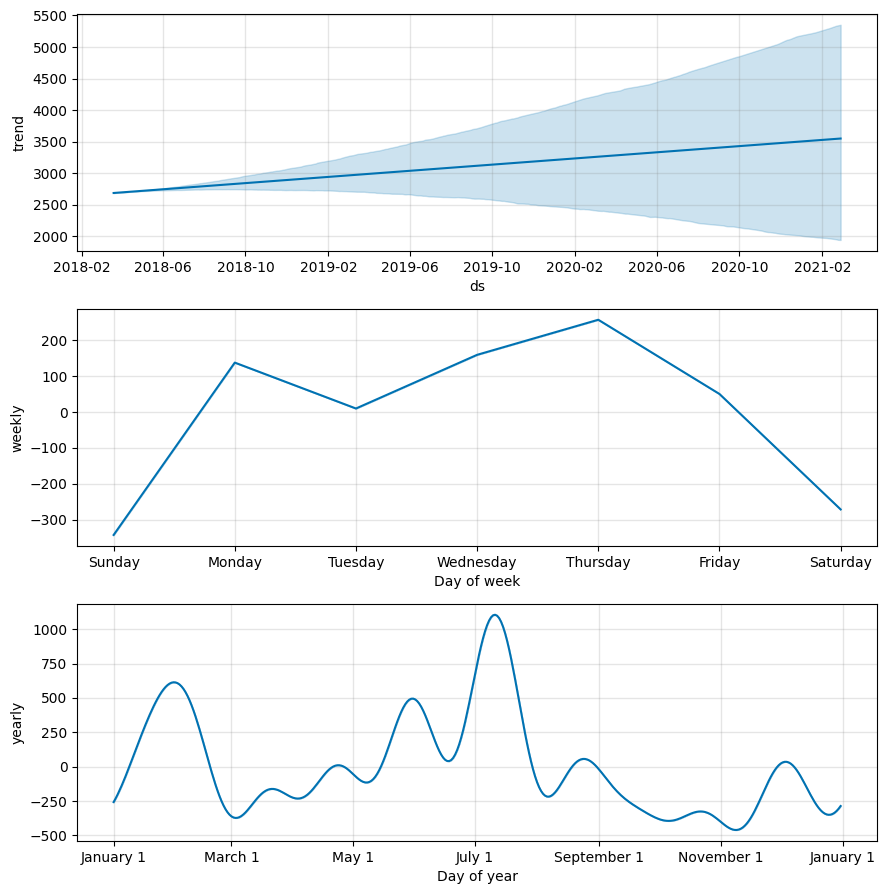

In [27]:
model_1.plot_components(pred1) 
plt.show()

In [28]:
df.head()

,Tmax,SysLoad,GasPrice,y
ds,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [29]:
#Rename "SysLoad", "Tmax", and "GasPrice" to "add1", "add2", and "add3" respectively
new_df = df_daily.rename(columns={"SysLoad" : "add1" , "Tmax" : "add2", "GasPrice" : "add3" })
new_df.head()

,ds,add2,add1,add3,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [30]:
# assign train and test data
train2 = new_df[:2757]
test2 = new_df[2757:]
print('train shape', train2.shape)
print('test shape', test2.shape)

train shape (2757, 5)
test shape (1077, 5)


In [31]:
#Create multivariate model
model_2 = Prophet()

model_2.add_regressor('add1')
model_2.add_regressor('add2')
model_2.add_regressor('add3')

In [32]:
model_2.fit(train2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkqfqgk6z/jsavalno.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkqfqgk6z/grbgkjtd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60566', 'data', 'file=/tmp/tmpkqfqgk6z/jsavalno.json', 'init=/tmp/tmpkqfqgk6z/grbgkjtd.json', 'output', 'file=/tmp/tmpkqfqgk6z/prophet_model82pt_t7o/prophet_model-20230403061503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:15:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [33]:
#getting the model's prediction

pred2 = model_2.predict(test2)

In [34]:
#Evaluate MAPE on the test set
mape(test['y'],pred2['yhat'])

232.73

In [35]:
#RMSE on test set
rmse(test2['y'],pred2['yhat'])

2708.53

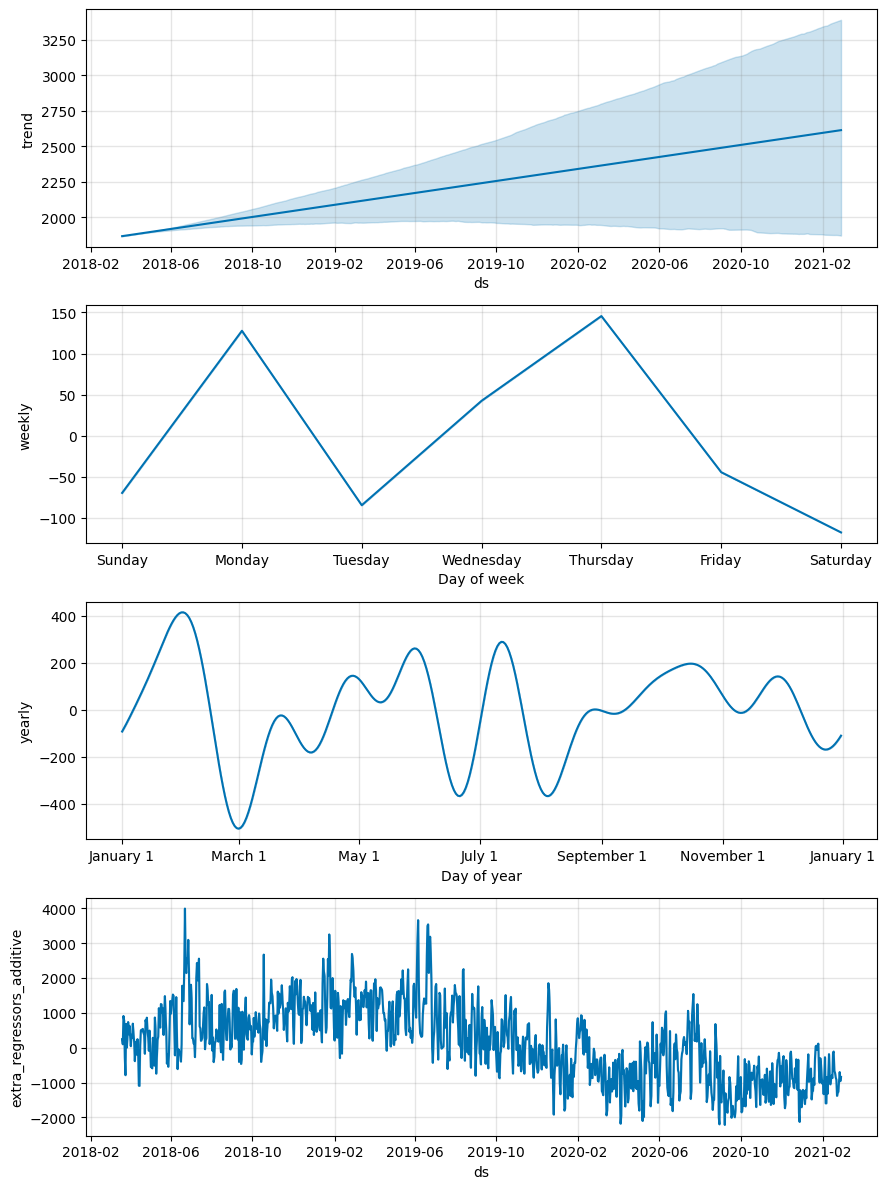

In [36]:
model_2.plot_components(pred2) 
plt.show()

In [37]:
# Split the dataset
train3 = new_df.iloc[:2757,:]
test3 = new_df.iloc[2757:,:]
train3.shape , test3.shape

((2757, 5), (1077, 5))

In [38]:
#Training a forecast model without 'Tmax' 
model_3 = Prophet()
model_3.add_regressor('add1')
model_3.add_regressor('add3')

In [39]:
model_3.fit(train3)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkqfqgk6z/9ennwn14.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkqfqgk6z/gk_i9dib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29403', 'data', 'file=/tmp/tmpkqfqgk6z/9ennwn14.json', 'init=/tmp/tmpkqfqgk6z/gk_i9dib.json', 'output', 'file=/tmp/tmpkqfqgk6z/prophet_model0fp4ilxh/prophet_model-20230403061507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:15:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [40]:
#getting the model's prediction
pred3 = model_3.predict(test3) 

In [41]:
#Evaluate MAPE on the test set
mape(test3['y'],pred3['yhat'])

232.84

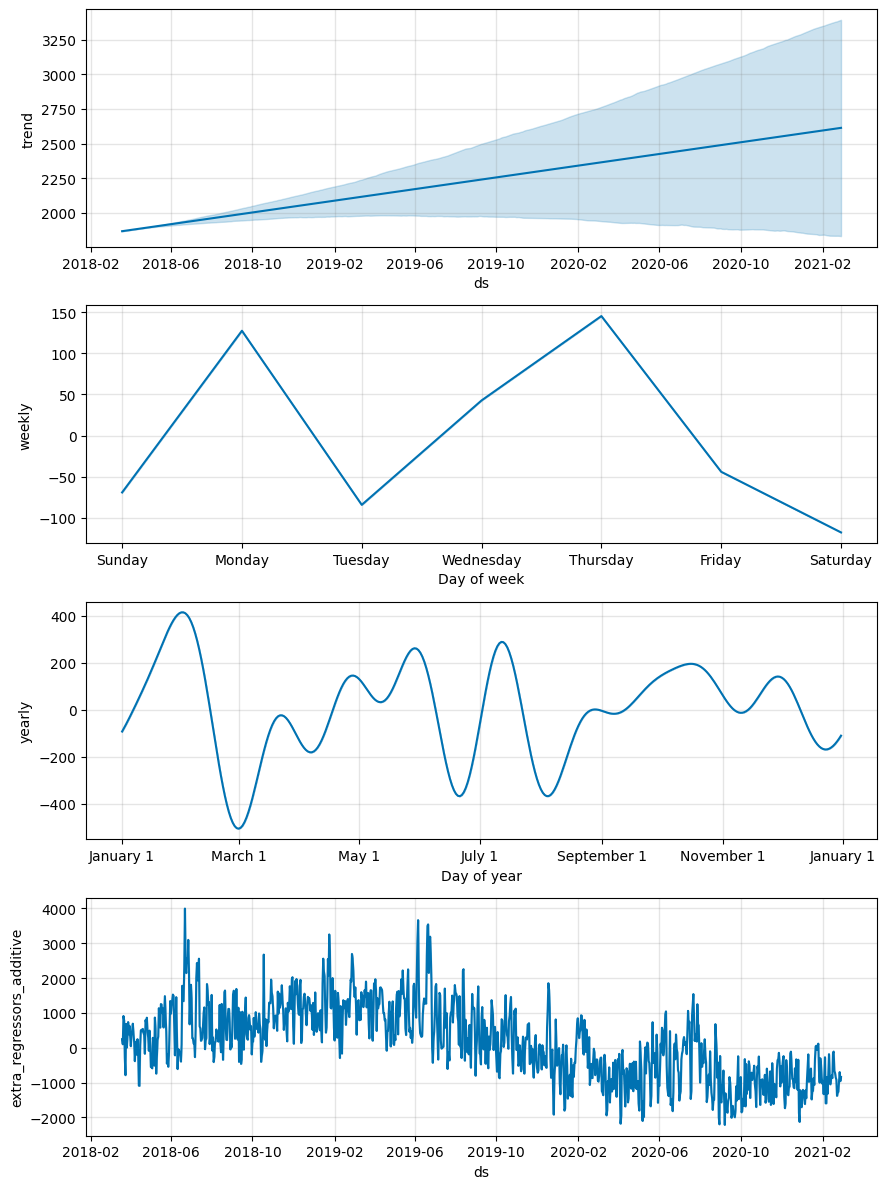

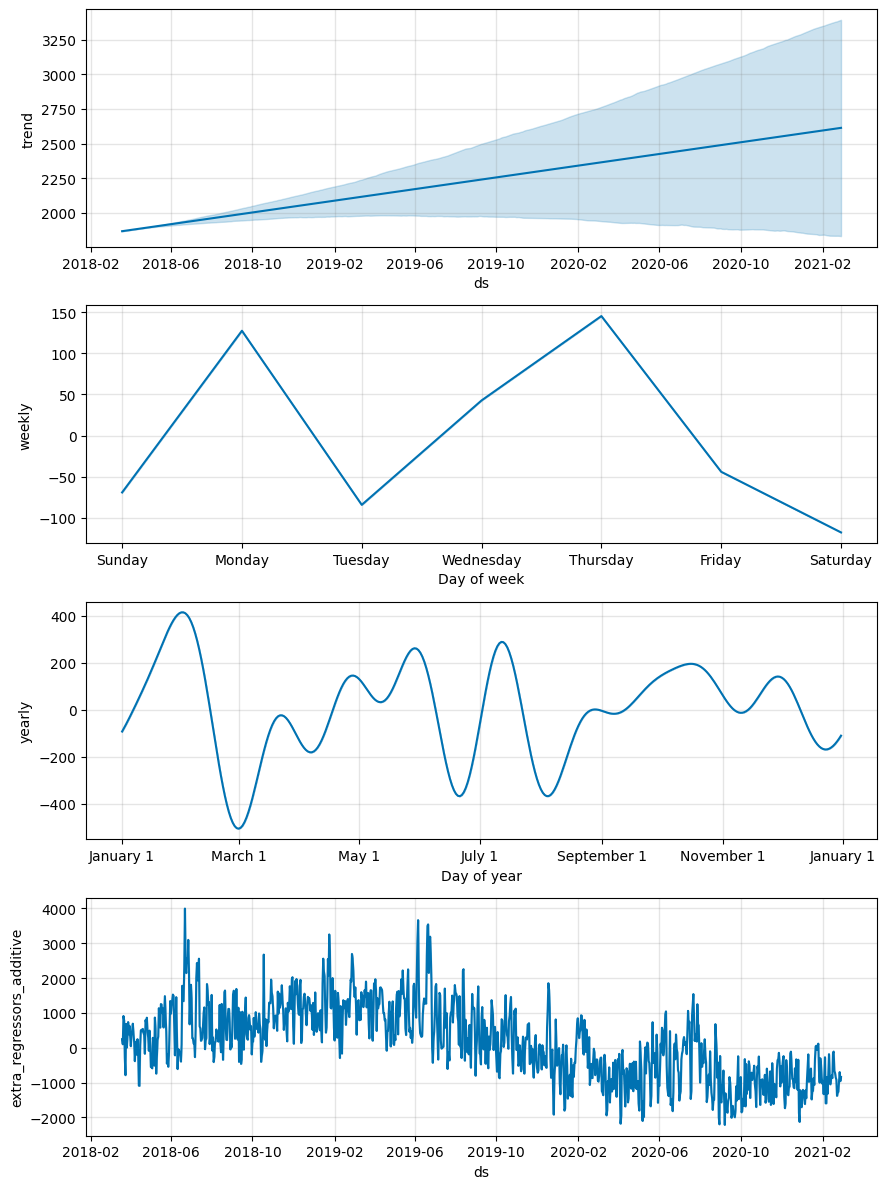

In [42]:
model_3.plot_components(pred3)